# Access and plot AROME MetCoOp and ECMWF IFS forecasts
## Example for an extreme precipitation event in October 2014 in West Norway

In [1]:
# Activate the following in colab : 
#!pip3 install netCDF4
#!apt install proj-bin libproj-dev libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
    
import xarray as xr

/home/maltem/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


##### Specifiy input fields: AROME MetCoOp and ECMWF IFS forecasts

In [2]:
day='26'; month='10'; year='2014'; HH='12'

url='https://thredds.met.no/thredds/dodsC/aromemetcoopstarc/'+str(year)+'/'+str(month)+'/'+str(day)+'/AROME_MetCoOp_'+str(HH)+'_fp.nc_'+str(year)+str(month)+str(day)
arome = xr.open_dataset(url)

url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/Arctic.ECMWF_extracted_'+str(year)+str(month)+str(day)+'T'+str(HH)+'Z.nc'
ecifs =  xr.open_dataset(url)

### Find a specific point and plot the forecast. 
###### Note AROME MetCoOp is on an irregular grid, so the xarray.sel functionality does not work. But it does work for the ECMWF IFS grid (see below)

In [4]:
import math
import numpy as np

def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    latlon_idx = np.argmin(c)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [5]:
lat0=60.3833; lon0=5.9500 # Kvamskogen in Western Norway

[ix,jx] = findindex(arome.latitude,arome.longitude,lat0,lon0) # from regional model AROME MetCoOp


### The ECMWF IFS precipitation is subdivided into large scale or stratiform precipitation (LSP) and convective precipitation (TP-LSP)

In [ ]:
ecifs

In [8]:
pp_acc_point_arome = arome.precipitation_amount_acc[:,0,ix,jx]
pp_acc_point_ecifs = ecifs.sel(lat=lat0,lon=lon0,method='nearest')

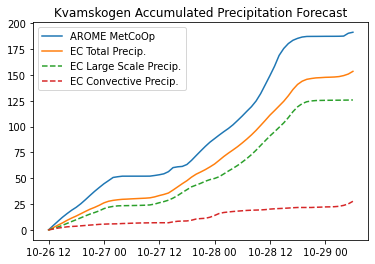

In [9]:
from matplotlib import pyplot as plt

plt.plot(arome.time, pp_acc_point_arome, '-',label='AROME MetCoOp')
plt.plot(ecifs.time, pp_acc_point_ecifs.TP*1000,'-',label='EC Total Precip.')
plt.plot(ecifs.time, pp_acc_point_ecifs.LSP*1000, '--',label='EC Large Scale Precip.')
plt.plot(ecifs.time, (pp_acc_point_ecifs.TP-pp_acc_point_ecifs.LSP)*1000, '--',label='EC Convective Precip.')

plt.title("Kvamskogen Accumulated Precipitation Forecast")
plt.legend()
plt.show()

### Plot the two accumulated precipitation forecasts on a map

/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'extemd'
/usr/lib/python3/dist-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'extemd'


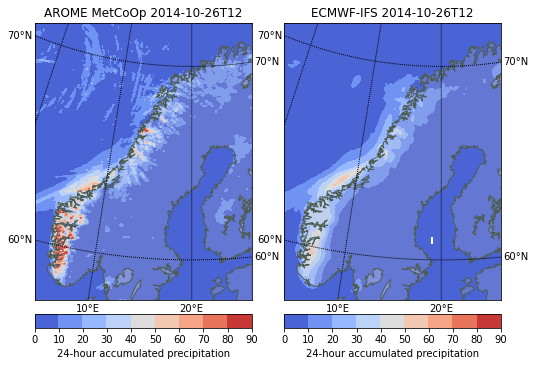

In [10]:
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

timestep=24 # 24-hour accumulated precipitation
levelsPP = range(0,100,10)

fig = plt.figure(figsize=(7.2,7.2)) 
gs = gridspec.GridSpec(1, 2)
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.05, wspace=0.15, hspace=0.05)

m = Basemap(projection='stere', 
            boundinglat=57, lon_0=20, lat_0=62.4, 
            resolution='l', 
            llcrnrlat= 57.0, urcrnrlat=72.0, llcrnrlon=5.0, urcrnrlon=30.0)

# PLOT (1) REGIONAL MODEL

ax = plt.subplot(gs[0],aspect='equal')
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(np.array(arome.longitude),np.array(arome.latitude))               # compute map proj coordinates.
cs=m.contourf(x,y,np.array( arome.precipitation_amount_acc[timestep,0,:,:]),
              cmap=plt.cm.coolwarm,extemd='max',levels=levelsPP)

plt.title ('AROME MetCoOp '+np.datetime_as_string(arome.time[0],unit='h'))
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('24-hour accumulated precipitation')    


# PLOT (2) GLOBAL MODEL
ax = plt.subplot(gs[1],aspect='equal')
m.drawcoastlines(color='#4D5D53'); m.fillcontinents(alpha=0.2)
parallels = np.arange(0.,90,10); m.drawparallels(parallels,labels=[1,1,1,0],fontsize=10)
meridians = np.arange(0.,360.,10); m.drawmeridians(meridians,labels=[0,0,0,1],latmax=80,fontsize=10)
x, y = m(*np.meshgrid(ecifs.lon,ecifs.lat))
cs=m.contourf(x,y,np.array( ecifs.TP[timestep,:,:]*1000),
              cmap=plt.cm.coolwarm,extemd='max',levels=levelsPP)
plt.title ('ECMWF-IFS '+np.datetime_as_string(ecifs.time[0],unit='h'))
cbar = m.colorbar(cs,location='bottom',pad="5%")  
cbar.set_label('24-hour accumulated precipitation')    